In [96]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [98]:
# Merge all csv in One csv only with the Scores.

# Relative path
relative_path = os.path.join("Resources", "WHR", "*.csv")
file_paths = glob.glob(relative_path)

# Function to load and prepare data
def load_and_prepare_data(file_path):
    year = file_path[-8:-4]  # Extracting year from the file name
    df = pd.read_csv(file_path)
    
    # Normalizing the happiness score column name
    score_col = None
    if 'Happiness Score' in df.columns:
        score_col = 'Happiness Score'
    elif 'Happiness.Score' in df.columns:
        score_col = 'Happiness.Score'
    elif 'Score' in df.columns:
        score_col = 'Score'
    elif 'Happiness score' in df.columns:
        score_col = 'Happiness score'
    elif 'Ladder score' in df.columns:
        score_col = 'Ladder score'
    
    country_col = None
    if 'Country' in df.columns:
        country_col = 'Country'
    elif 'Country name' in df.columns:
        country_col = 'Country name'
    elif 'Country or region' in df.columns:
        country_col = 'Country or region'
    
    if score_col and country_col:
        df = df[[country_col, score_col]].rename(columns={score_col: 'Happiness Score', country_col: 'Country'})
        df['Year'] = int(year)
        return df
    else:
        print(f"Warning: No recognized happiness score or country column in {file_path}")
        return None

# Load and concatenate all data
data_frames = [load_and_prepare_data(file) for file in file_paths]
data_frames = [df for df in data_frames if df is not None]  # Filter out None entries

happiness_data = pd.concat(data_frames, ignore_index=True)

# Save to CSV file
output_file = os.path.join('Resources', 'Happiness_data_merged.csv')
happiness_data.to_csv(output_file, index=False)

# Print a sample of the concatenated data
happiness_data.head()

,Country,Happiness Score,Year
0,Finland,7.821,2022
1,Denmark,7.636,2022
2,Iceland,7.557,2022
3,Switzerland,7.512,2022
4,Netherlands,7.415,2022


In [120]:
happiness_data_t= happiness_data.pivot(index='Country', columns='Year', values='Happiness Score')
happiness_data_t.head()
happiness_data_t= happiness_data_t.sort_values(by=2023, ascending= False)
happy_10 = happiness_data_t.index[:10].tolist()
happy_10

['Finland',
 'Denmark',
 'Iceland',
 'Israel',
 'Netherlands',
 'Sweden',
 'Norway',
 'Switzerland',
 'Luxembourg',
 'New Zealand']

In [59]:
# Read Suicide data
suicide_data_path = os.path.join('Resources', 'suicide_rates.csv')
suicide_data = pd.read_csv(suicide_data_path)

# Correct columns
suicide_data.rename(columns={'country': 'Country'}, inplace=True)
suicide_data.rename(columns={'year': 'Year'}, inplace=True)

# Convert 'year' column to numeric (if not already)
suicide_data['Year'] = pd.to_numeric(suicide_data['Year'], errors='coerce')

# Filter for years 2015-2023
suicide_data = suicide_data[suicide_data['Year'].between(2015, 2023)]

# Aggregate population and suicides_no by country and year
aggregated_data = suicide_data.groupby(['Country', 'Year']).agg({
    'population': 'sum',
    'suicides_no': 'sum'
}).reset_index()

# Suicides per 100,000 population
aggregated_data['suicides_per_100k'] = (aggregated_data['suicides_no'] / aggregated_data['population']) * 100000

# Drop 'suicides_no' and 'population' columns
aggregated_data.drop('population', axis=1, inplace=True)

# Pivot the data to transpose years into columns
transposed_data = aggregated_data.pivot(index='Country', columns='Year', values='suicides_per_100k')

# Save to CSV file
output = os.path.join('Resources', 'Suicide_cleaned.csv')
aggregated_data.to_csv(output, index=False)

aggregated_data.head()

,Country,Year,suicides_no,suicides_per_100k
0,Antigua and Barbuda,2015,1.0,1.08827
1,Antigua and Barbuda,2017,0.0,0.00000
2,Antigua and Barbuda,2018,0.0,0.00000
3,Antigua and Barbuda,2019,0.0,0.00000
4,Antigua and Barbuda,2020,0.0,0.00000


In [169]:
# Merge suicides per 100k into the main dataframe
happy_suicide_data = pd.merge(happiness_data, aggregated_data, on=['Country', 'Year'])
# Save to CSV file
output = os.path.join('Resources', 'Happy_suicide_merged.csv')
aggregated_data.to_csv(output, index=False)
# Sort by suicide
happy_suicide_data = happy_suicide_data.sort_values(by='suicides_no', ascending=False)
# Reset index
happy_suicide_data= happy_suicide_data.reset_index()

# Unique countries
unique_countries = happy_suicide_data['Country'].unique()

# first 10 unique countries
suicide_10 = unique_countries[:10].tolist()
print(suicide_10)

# Sort by suicide per 100K
happy_suicide_100K = happy_suicide_data.sort_values(by='suicides_per_100k', ascending=False).reset_index()

# Unique countries
unique_countries2 = happy_suicide_100K['Country'].unique()

# first 10 unique countries
suicide_10_1 = unique_countries2[:10].tolist()
print(suicide_10_1)

# Intersection
common_countries = set(suicide_10).intersection(set(suicide_10_1))
print(common_countries)

['United States', 'Japan', 'Brazil', 'Germany', 'Ukraine', 'Mexico', 'United Kingdom', 'Thailand', 'Poland', 'Canada']
['Slovakia', 'Lithuania', 'Slovenia', 'Hungary', 'Latvia', 'Uruguay', 'Mongolia', 'Japan', 'Croatia', 'Ukraine']
{'Japan', 'Ukraine'}


# Line plot
## Top 10: 2023 'Happy' Countries VS. Top 10: Suicide countries

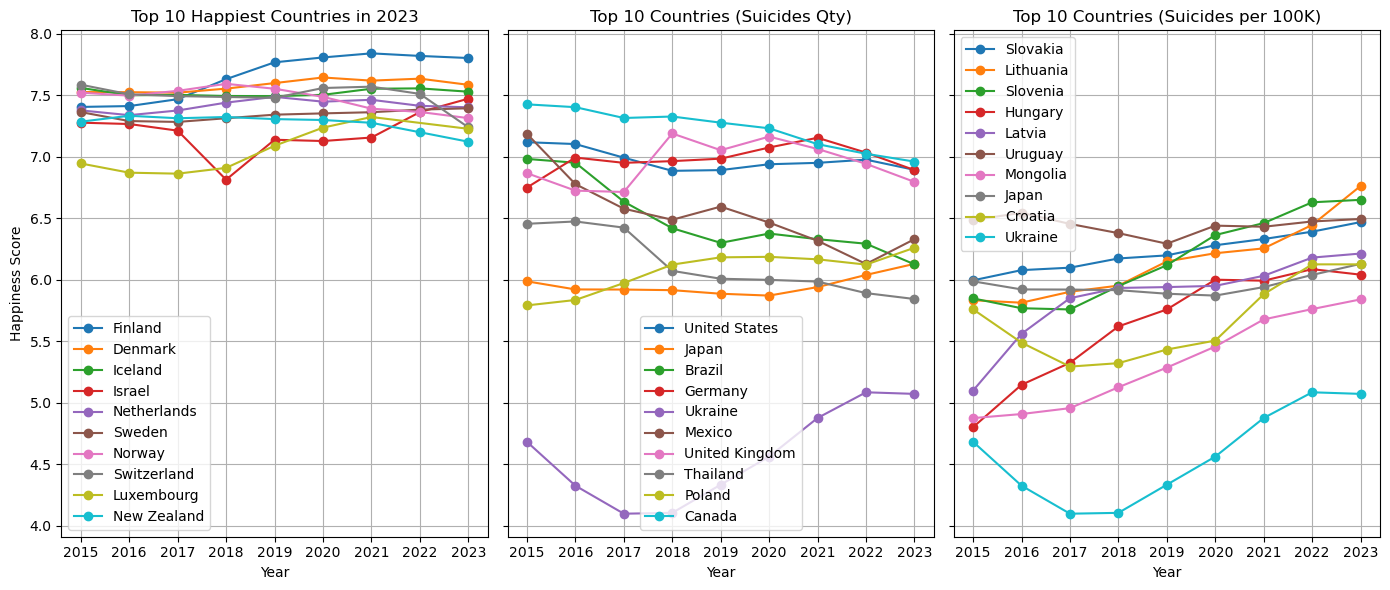

In [179]:
# Filter DataFrame for countries in happy_10 and suicide_10 lists, sorted by Year
happy_filtered = happiness_data[happiness_data['Country'].isin(happy_10)].sort_values(by='Year')
suicide_filtered = happiness_data[happiness_data['Country'].isin(suicide_10)].sort_values(by='Year')
suicide_filtered2 = happiness_data[happiness_data['Country'].isin(suicide_10_1)].sort_values(by='Year')

# Create subplots with shared y-axis (Happiness Score)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharey=True)

# Plotting for happy_10 countries
for country in happy_10:
    country_data = happy_filtered[happy_filtered['Country'] == country]
    ax1.plot(country_data['Year'], country_data['Happiness Score'], marker='o', label=country)

ax1.set_title('Top 10 Happiest Countries in 2023')
ax1.set_xlabel('Year')
ax1.set_ylabel('Happiness Score')
ax1.legend()
ax1.grid(True)

# Plotting for Suicides per 100K countries
for country in suicide_10_1:
    country_data = suicide_filtered2[suicide_filtered2['Country'] == country]
    ax3.plot(country_data['Year'], country_data['Happiness Score'], marker='o', label=country)

ax3.set_title('Top 10 Countries (Suicides per 100K)')
ax3.set_xlabel('Year')
ax3.legend()
ax3.grid(True)

# Plotting for total suicide countries
for country in suicide_10:
    country_data = suicide_filtered[suicide_filtered['Country'] == country]
    ax2.plot(country_data['Year'], country_data['Happiness Score'], marker='o', label=country)

ax2.set_title('Top 10 Countries (Suicides Qty)')
ax2.set_xlabel('Year')
ax2.legend()
ax2.grid(True)


plt.tight_layout()
plt.savefig("Images/Fig1.png")
plt.show()

## 1. Scatter Plot with Regression Line ALL DATA

### Remove outliers and zeros

In [136]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for suicides_per_100k
Q1_suicides_per_100k = happy_suicide_data['suicides_per_100k'].quantile(0.25)
Q3_suicides_per_100k = happy_suicide_data['suicides_per_100k'].quantile(0.75)

# Calculate the IQR for suicides_per_100k
IQR_suicides_per_100k = Q3_suicides_per_100k - Q1_suicides_per_100k

# Define the lower and upper bounds for outliers for suicides_per_100k
lower_bound_suicides_per_100k = Q1_suicides_per_100k - 1.5 * IQR_suicides_per_100k
upper_bound_suicides_per_100k = Q3_suicides_per_100k + 1.5 * IQR_suicides_per_100k

# Filter out the outliers and zeros for suicides_per_100k
filtered_data_per_100k = happy_suicide_data[
    (happy_suicide_data['suicides_per_100k'] >= lower_bound_suicides_per_100k) &
    (happy_suicide_data['suicides_per_100k'] <= upper_bound_suicides_per_100k) &
    (happy_suicide_data['suicides_per_100k'] > 0) &
    (happy_suicide_data['suicides_no'] > 0)
]
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for suicides_no
Q1_suicides_no = happy_suicide_data['suicides_no'].quantile(0.25)
Q3_suicides_no = happy_suicide_data['suicides_no'].quantile(0.75)

# Calculate the IQR for suicides_no
IQR_suicides_no = Q3_suicides_no - Q1_suicides_no

# Define the lower and upper bounds for outliers for suicides_no
lower_bound_suicides_no = Q1_suicides_no - 1.5 * IQR_suicides_no
upper_bound_suicides_no = Q3_suicides_no + 1.5 * IQR_suicides_no

# Filter out the outliers and zeros for suicides_no
filtered_data_suicides_no = happy_suicide_data[
    (happy_suicide_data['suicides_no'] >= lower_bound_suicides_no) &
    (happy_suicide_data['suicides_no'] <= upper_bound_suicides_no) &
    (happy_suicide_data['suicides_no'] > 0)
]

## Line Plots w/regression lines

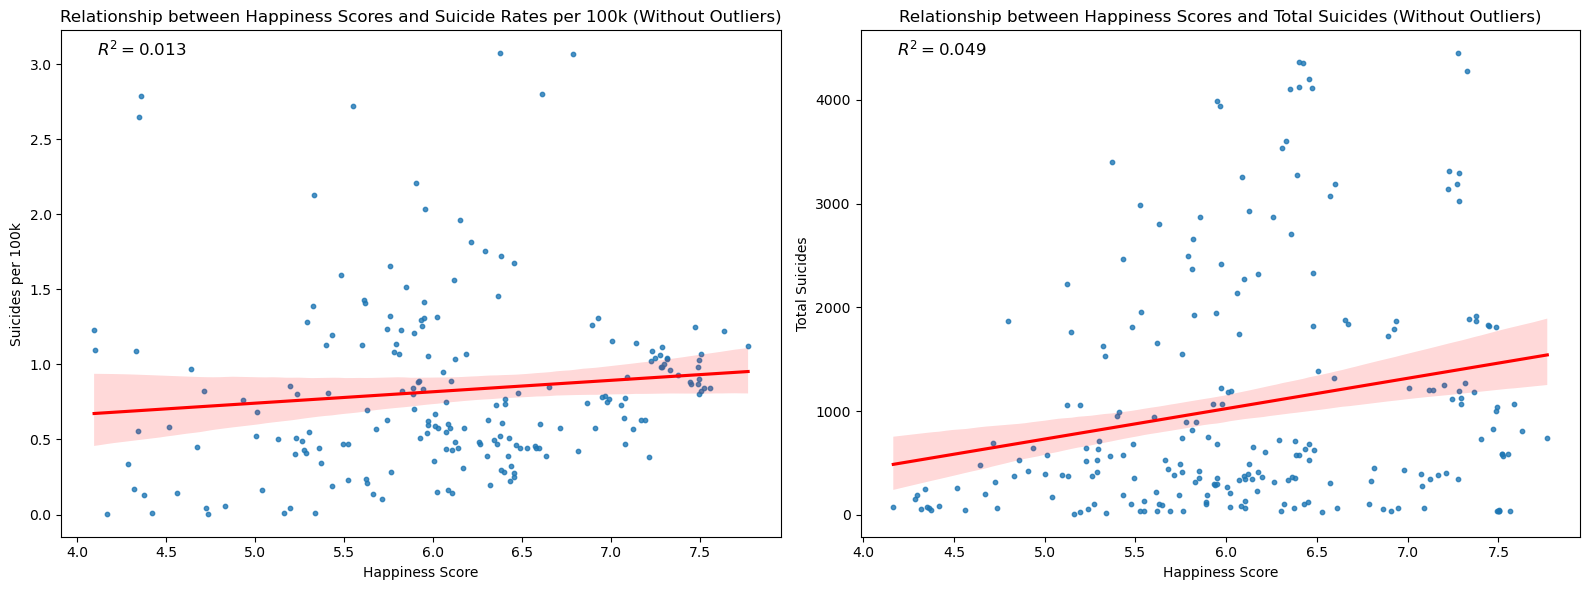

In [182]:
# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot 1: Relationship between Happiness Scores and Suicide Rates (suicides_per_100k)
sns.regplot(x='Happiness Score', y='suicides_per_100k', data=filtered_data_per_100k, scatter_kws={'s':10}, line_kws={"color":"r"}, ax=ax1)
ax1.set_title('Relationship between Happiness Scores and Suicide Rates per 100k (Without Outliers)')
ax1.set_xlabel('Happiness Score')
ax1.set_ylabel('Suicides per 100k')

# Calculate R-squared for suicides_per_100k
x_per_100k = filtered_data_per_100k['Happiness Score']
y_per_100k = filtered_data_per_100k['suicides_per_100k']
slope_per_100k, intercept_per_100k, r_value_per_100k, p_value_per_100k, std_err_per_100k = stats.linregress(x_per_100k, y_per_100k)
r_squared_per_100k = r_value_per_100k**2

# Annotate the plot with R-squared for suicides_per_100k
ax1.annotate(f'$R^2 = {r_squared_per_100k:.3f}$', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

# Plot 2: Relationship between Happiness Scores and Total Suicides (suicides_no)
sns.regplot(x='Happiness Score', y='suicides_no', data=filtered_data_suicides_no, scatter_kws={'s':10}, line_kws={"color":"r"}, ax=ax2)
ax2.set_title('Relationship between Happiness Scores and Total Suicides (Without Outliers)')
ax2.set_xlabel('Happiness Score')
ax2.set_ylabel('Total Suicides')

# Calculate R-squared for suicides_no
x_suicides_no = filtered_data_suicides_no['Happiness Score']
y_suicides_no = filtered_data_suicides_no['suicides_no']
slope_suicides_no, intercept_suicides_no, r_value_suicides_no, p_value_suicides_no, std_err_suicides_no = stats.linregress(x_suicides_no, y_suicides_no)
r_squared_suicides_no = r_value_suicides_no**2

# Annotate the plot with R-squared for suicides_no
ax2.annotate(f'$R^2 = {r_squared_suicides_no:.3f}$', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

# Adjust layout and display plot
plt.tight_layout()
plt.savefig("Images/Fig2.png")
plt.show()

## 2. Histograms ALL DATA

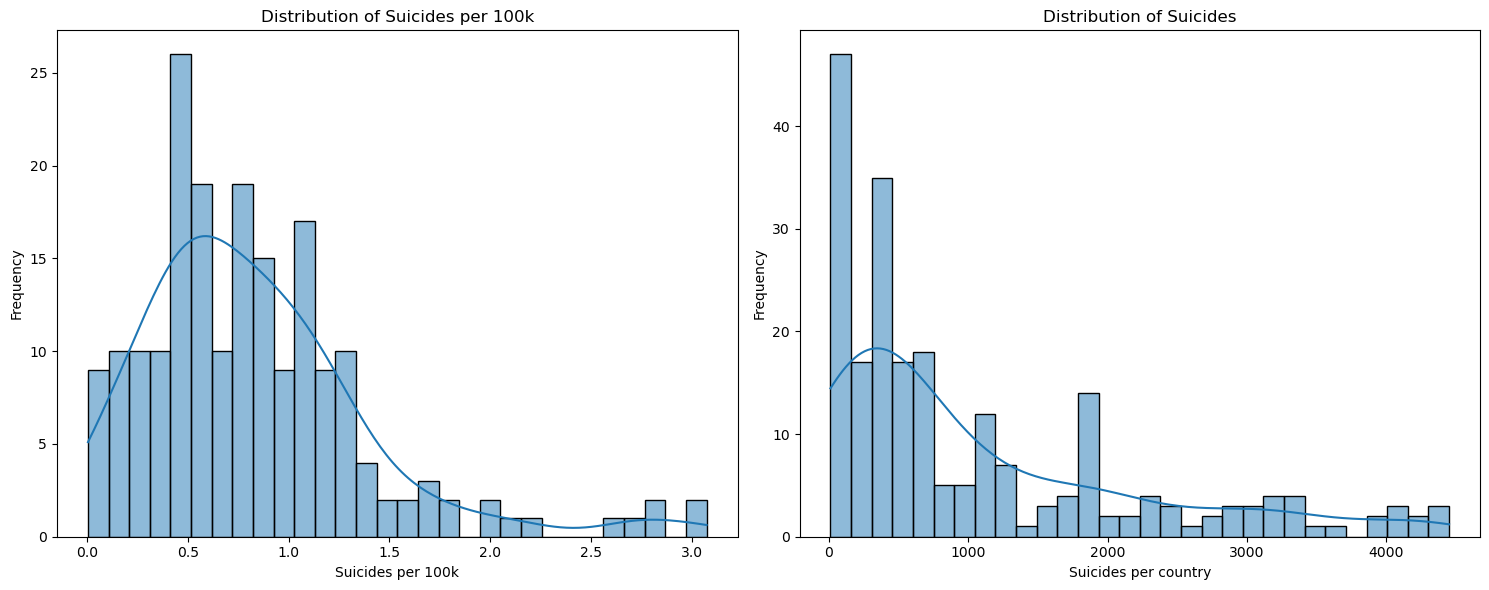

In [181]:
# Set up figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot 1: Distribution of 'suicides_per_100k'
sns.histplot(filtered_data_per_100k['suicides_per_100k'], bins=30, kde=True, ax=ax1)
ax1.set_title('Distribution of Suicides per 100k')
ax1.set_xlabel('Suicides per 100k')
ax1.set_ylabel('Frequency')

# Plot 2: Distribution of 'suicides_no'
sns.histplot(filtered_data_suicides_no['suicides_no'], bins=30, kde=True, ax=ax2)
ax2.set_title('Distribution of Suicides')
ax2.set_xlabel('Suicides per country')
ax2.set_ylabel('Frequency')

# Adjust layout and display plot
plt.tight_layout()
plt.savefig("Images/Fig3.png")
plt.show()

In [187]:
# Pearson correlation
pearson_corr_suicides_per_100k, p_value_pearson_per_100k = stats.pearsonr(filtered_data_per_100k['Happiness Score'], filtered_data_per_100k['suicides_per_100k'])
pearson_corr_suicides_no, p_value_pearson_no = stats.pearsonr(filtered_data_suicides_no['Happiness Score'], filtered_data_suicides_no['suicides_no'])

# Spearman correlation
spearman_corr_suicides_per_100k, p_value_spearman_per_100k = stats.spearmanr(filtered_data_per_100k['Happiness Score'], filtered_data_per_100k['suicides_per_100k'])
spearman_corr_suicides_no, p_value_spearman_no = stats.spearmanr(filtered_data_suicides_no['Happiness Score'], filtered_data_suicides_no['suicides_no'])

print(f"Pearson correlation (Happiness Score vs. Suicides per 100k): {pearson_corr_suicides_per_100k:.3f}, p-value: {p_value_pearson_per_100k:.3f}")
print(f"Pearson correlation (Happiness Score vs. Suicides no): {pearson_corr_suicides_no:.3f}, p-value: {p_value_pearson_no:.5f}")
print(f"Spearman correlation (Happiness Score vs. Suicides per 100k): {spearman_corr_suicides_per_100k:.3f}, p-value: {p_value_spearman_per_100k:.3f}")
print(f"Spearman correlation (Happiness Score vs. Suicides no): {spearman_corr_suicides_no:.3f}, p-value: {p_value_spearman_no:.5f}")


Pearson correlation (Happiness Score vs. Suicides per 100k): 0.115, p-value: 0.109
Pearson correlation (Happiness Score vs. Suicides no): 0.222, p-value: 0.00079
Spearman correlation (Happiness Score vs. Suicides per 100k): 0.193, p-value: 0.007
Spearman correlation (Happiness Score vs. Suicides no): 0.238, p-value: 0.00031
